<a href="https://www.kaggle.com/code/chogerlate/mba-analysis-and-modeling?scriptVersionId=199410759" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mba-admission-dataset/MBA.csv


In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

### Dataset Analysis
About Dataset
1. Data Source:
Synthetic data generated from the Wharton Class of 2025's statistics.

2. Meta Data:
  - application_id: Unique identifier for each application
  - gender: Applicant's gender (Male, Female)
  - international: International student (TRUE/FALSE)
  - gpa: Grade Point Average of the applicant (on 4.0 scale)
  - major: Undergraduate major (Business, STEM, Humanities)
  - race: Racial background of the applicant (e.g., White, Black, Asian, Hispanic, Other / null: international student)
  - gmat: GMAT score of the applicant (800 points)
  - work_exp: Number of years of work experience (Year)
  - work_industry: Industry of the applicant's previous work experience (e.g., - Consulting, Finance, Technology, etc.)
  - admission: Admission status (Admit, Waitlist, Null: Deny)
3. Usage:
Exploratory Data Analysis (EDA): Understand the distributions, relationships, and patterns within the data.
Classification: Predict the admission status based on other features.

In [125]:
df = pd.read_csv('/kaggle/input/mba-admission-dataset/MBA.csv')
df

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN
...,...,...,...,...,...,...,...,...,...,...
6189,6190,Male,False,3.49,Business,White,640.0,5.0,Other,NaN
6190,6191,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,NaN
6191,6192,Female,True,3.22,Business,NaN,680.0,5.0,Health Care,Admit
6192,6193,Male,True,3.36,Business,NaN,590.0,5.0,Other,NaN


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


### Data pre-processing

Fill missing value:
    
    - Fill na value inside admission column with 'Reject'.
    
Replace inf/-inf value:
    
    - Replace inf/-inf values inside our dataframe with na value 


In [127]:
# Fill na
df['admission'] = df['admission'].fillna('Reject')
# Replace inf and -inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

Target encode:
    Label encode `admission` column using label encoding strategy

In [128]:
le = LabelEncoder()
df['admission'] = le.fit_transform(df['admission'])  

In [129]:
for idx, clx in enumerate(le.classes_):
    print(idx, clx)

0 Admit
1 Reject
2 Waitlist


### Initial EDA

Basic descriptive statistics

In [106]:
df.describe()

,application_id,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000,6194.000000
mean,3097.500000,3.250714,651.092993,5.016952
std,1788.198115,0.151541,49.294883,1.032432
min,1.000000,2.650000,570.000000,1.000000
25%,1549.250000,3.150000,610.000000,4.000000
50%,3097.500000,3.250000,650.000000,5.000000
75%,4645.750000,3.350000,680.000000,6.000000
max,6194.000000,3.770000,780.000000,9.000000


Gender Distribution: The dataset appears to have a nearly equal distribution between male and female applicants.

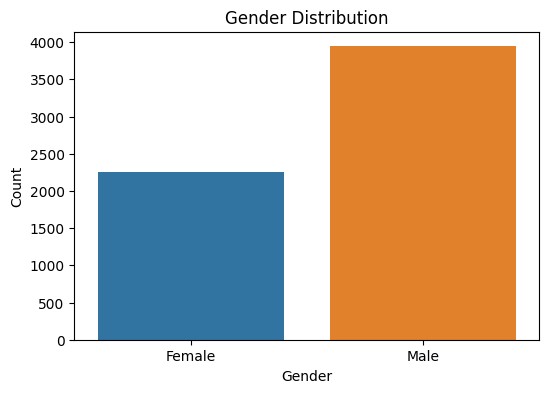

In [107]:
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Most applicants have a GPA between 3.1 and 3.4, with few outliers at both ends.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


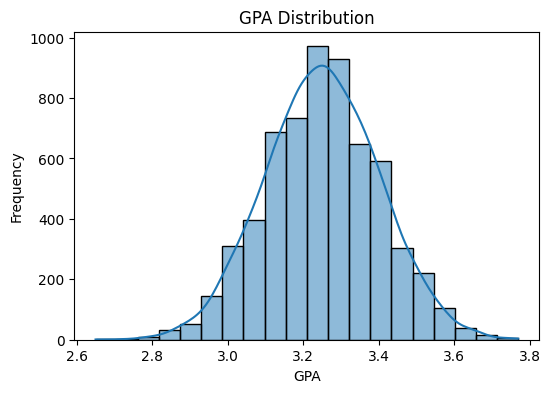

In [108]:
plt.figure(figsize=(6, 4))
sns.histplot(df['gpa'], kde=True, bins=20)
plt.title('GPA Distribution')
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.show()

GMAT scores are normally distributed, with a peak around the 640-660 range.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


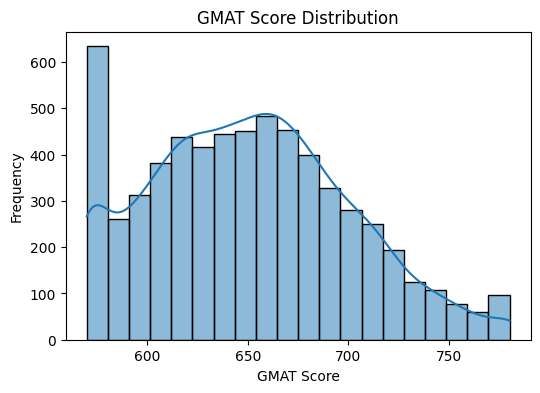

In [109]:
plt.figure(figsize=(6, 4))
sns.histplot(df['gmat'], kde=True, bins=20)
plt.title('GMAT Score Distribution')
plt.xlabel('GMAT Score')
plt.ylabel('Frequency')
plt.show()

There is a huge imbalance in the number of admit, reject, and waitlist applications.

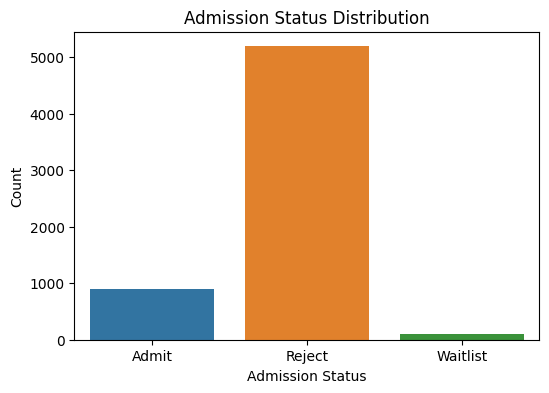

In [110]:
plt.figure(figsize=(6, 4))
sns.countplot(x='admission', data=df)
plt.title('Admission Status Distribution')
plt.xlabel('Admission Status')
plt.ylabel('Count')
plt.show()

Correlation heatmap of numeric variables: 
* The heatmap shows little to no correlation between GPA, GMAT, and work experience, indicating that these factors might contribute independently to the admission decision.
* After I experiment with both dataset processing and modeling for awhile I found that only 2 factors which is 'gpa' and 'gmat' worth consideration as feaetures for our admission prediction model

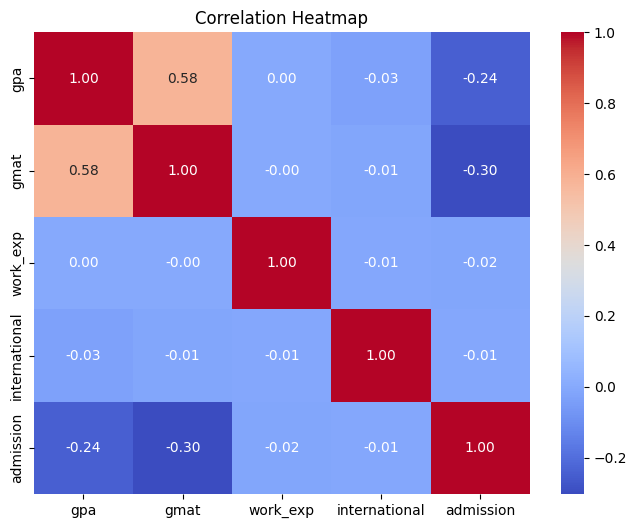

In [130]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['gpa', 'gmat', 'work_exp', 'international', 'admission']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Data processing
Drop columns:

    - drop race and gender due to Ethical and Bias Considerations.
    - drop application_id due to Irrelevant.

Drop rows:
    
    - Drop rows with the missing gpa, 

Encoding:

    One-hot encode categorical variables (major, work_industry).

Scaling:

    Normalize continuous features like gpa, gmat, and work_exp if needed to improve model performance.
   

In [131]:
df = df.drop(columns=['race', 'application_id', 'gender', 'major', 'work_industry', 'work_exp'])

# One-hot encode categorical variables
# df = pd.get_dummies(df, columns=['major', 'work_industry'], dummy_na=False)

# # Normalize continuous features (if needed)
scaler = MinMaxScaler()
continuous_features = ['gpa', 'gmat']
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [132]:
admission_counts = df['admission'].value_counts()
print(admission_counts)

admission
1    5194
0     900
2     100
Name: count, dtype: int64


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   international  6194 non-null   bool   
 1   gpa            6194 non-null   float64
 2   gmat           6194 non-null   float64
 3   admission      6194 non-null   int64  
dtypes: bool(1), float64(2), int64(1)
memory usage: 151.3 KB


### Split training and testing datasets
split the dataframe into training and testing datasets, ensuring that the test dataset contains 20 samples from each class. 

This method ensures that you have exactly 20 samples from each class in the test dataset while the rest are in the training dataset.

In [134]:
# Split the test dataset by selecting 20 samples from each class
test_data_0 = df[df['admission'] == 0].sample(n=20, random_state=42)  # 20 samples from class 0
test_data_1 = df[df['admission'] == 1].sample(n=20, random_state=42)  # 20 samples from class 1
test_data_2 = df[df['admission'] == 2].sample(n=20, random_state=42)  # 20 samples from class 2

# Combine all test samples
test_data = pd.concat([test_data_0, test_data_1, test_data_2])

# Remove the test samples from the original dataframe to create the training dataset
train_data = df.drop(test_data.index)

# Check the results
print("Test dataset size:", test_data.shape)
print("Train dataset size:", train_data.shape)

Test dataset size: (60, 4)
Train dataset size: (6134, 4)


### Training data processing

* Down-sampling Reject class 
* Up-sampling Waitlist and Admit classes

In [135]:
from sklearn.utils import resample
# Extracting each class after correction
admit_class = train_data[train_data['admission'] == 0]
reject_class = train_data[train_data['admission'] == 1]
waitlist_class = train_data[train_data['admission'] == 2]

# Downsampling the Reject class
reject_downsampled = resample(reject_class, 
                              replace=False,  # Sample without replacement
                              n_samples=1000,  # Match the size of Admit class
                              random_state=42)

admit_upsampled = resample(admit_class, 
                              replace=True,  # Sample with replacement
                              n_samples=1000,  # Match the majority class size (Reject)
                              random_state=42)

waitlist_upsampled = resample(waitlist_class, 
                              replace=True,  # Sample with replacement
                              n_samples=1000,  # Match the majority class size (Reject)
                              random_state=42)


# Combine the downsampled Reject class with the other two classes
sampled_df = pd.concat([admit_upsampled, reject_downsampled, waitlist_upsampled])
sampled_df['admission'].value_counts()

admission
0    1000
1    1000
2    1000
Name: count, dtype: int64

### Training
* Hyperparameter tuning with GridSearchCV

In [139]:
X_train = sampled_df.drop('admission', axis=1)
y_train = sampled_df['admission']
X_test = test_data.drop('admission', axis=1)
y_test = test_data['admission']


# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the hyperparameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Perform grid search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

# Perform grid search for Gradient Boosting
gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
gb_grid_search.fit(X_train, y_train)

# Print best parameters and accuracy
print("Best parameters for Random Forest: ", rf_grid_search.best_params_)
print("Best accuracy for Random Forest: ", rf_grid_search.best_score_)

print("Best parameters for Gradient Boosting: ", gb_grid_search.best_params_)
print("Best accuracy for Gradient Boosting: ", gb_grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total t

### Model Evaluation

In [140]:
# Get the best estimator (model with best parameters) for Random Forest
best_rf_model = rf_grid_search.best_estimator_

# Get the best estimator (model with best parameters) for Gradient Boosting
best_gb_model = gb_grid_search.best_estimator_

# Evaluate the models on the test set
rf_test_accuracy = best_rf_model.score(X_test, y_test)
gb_test_accuracy = best_gb_model.score(X_test, y_test)

print("Random Forest Test Accuracy: ", rf_test_accuracy)
print("Gradient Boosting Test Accuracy: ", gb_test_accuracy)

# If you want more detailed evaluation (e.g., classification report, confusion matrix)
from sklearn.metrics import classification_report, confusion_matrix

# Random Forest performance
print("Random Forest Classification Report:")
print(classification_report(y_test, best_rf_model.predict(X_test)))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, best_rf_model.predict(X_test)))

# Gradient Boosting performance
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, best_gb_model.predict(X_test)))

print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, best_gb_model.predict(X_test)))

Random Forest Test Accuracy:  0.5
Gradient Boosting Test Accuracy:  0.4666666666666667
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.60      0.59        20
           1       0.48      0.75      0.59        20
           2       0.38      0.15      0.21        20

    accuracy                           0.50        60
   macro avg       0.48      0.50      0.46        60
weighted avg       0.48      0.50      0.46        60

Random Forest Confusion Matrix:
[[12  4  4]
 [ 4 15  1]
 [ 5 12  3]]
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        20
           1       0.44      0.75      0.56        20
           2       0.38      0.15      0.21        20

    accuracy                           0.47        60
   macro avg       0.46      0.47      0.43        60
weighted avg       0.46      0.47      0.43        60

Grad